In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow
%matplotlib inline

In [20]:
import os

In [21]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [22]:
metadata

array([PINS\pins_Aaron Paul\Aaron Paul0_262.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_247.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_248.jpg, ...,
       PINS\pins_zendaya\zendaya97.jpg, PINS\pins_zendaya\zendaya98.jpg,
       PINS\pins_zendaya\zendaya99.jpg], dtype=object)

In [24]:
labels

array(['pins_Aaron Paul', 'pins_Aaron Paul', 'pins_Aaron Paul', ...,
       'pins_zendaya', 'pins_zendaya', 'pins_zendaya'], dtype='<U29')

In [25]:
metadata[0]

PINS\pins_Aaron Paul\Aaron Paul0_262.jpg

In [27]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [29]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

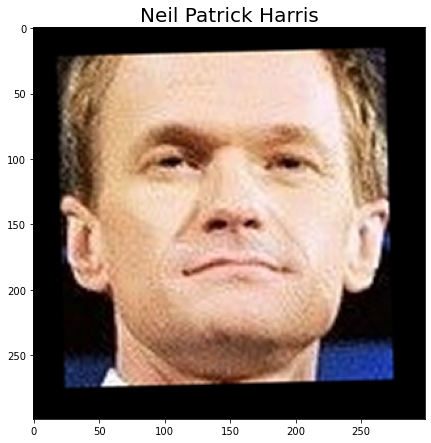

In [30]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [33]:
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [37]:
model = vgg_face()
model.load_weights('E:/mrinal/python/CV Project/vgg_face_weights.h5')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 128)    

In [38]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [39]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [41]:
from tqdm.notebook import tqdm
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

In [42]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [43]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

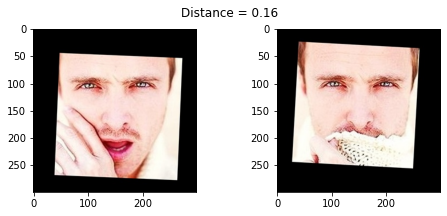

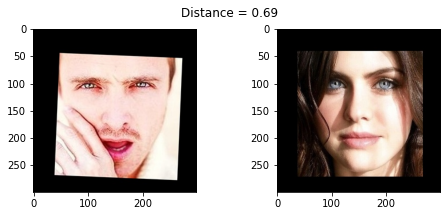

In [44]:
show_pair(2, 3)
show_pair(2, 180)

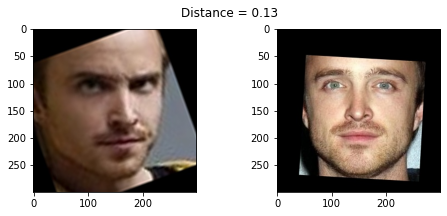

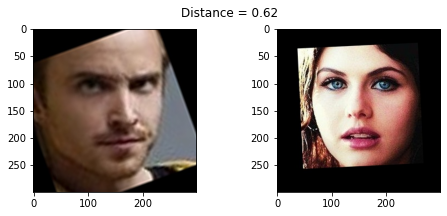

In [45]:
show_pair(30, 31)
show_pair(30, 100)

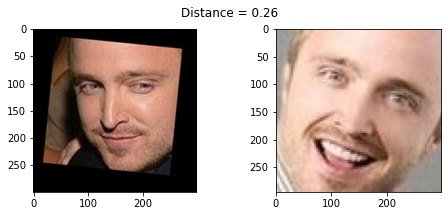

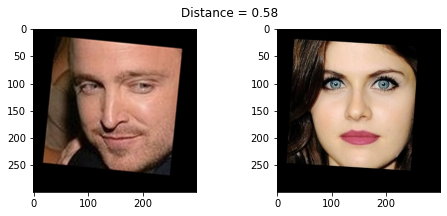

In [46]:
show_pair(70, 72)
show_pair(70, 115)

In [47]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [49]:
# Encode labels
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [50]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [51]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58416804  18.94867854  22.94242528 ...  99.99999983  99.99999999
 100.        ]


In [52]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


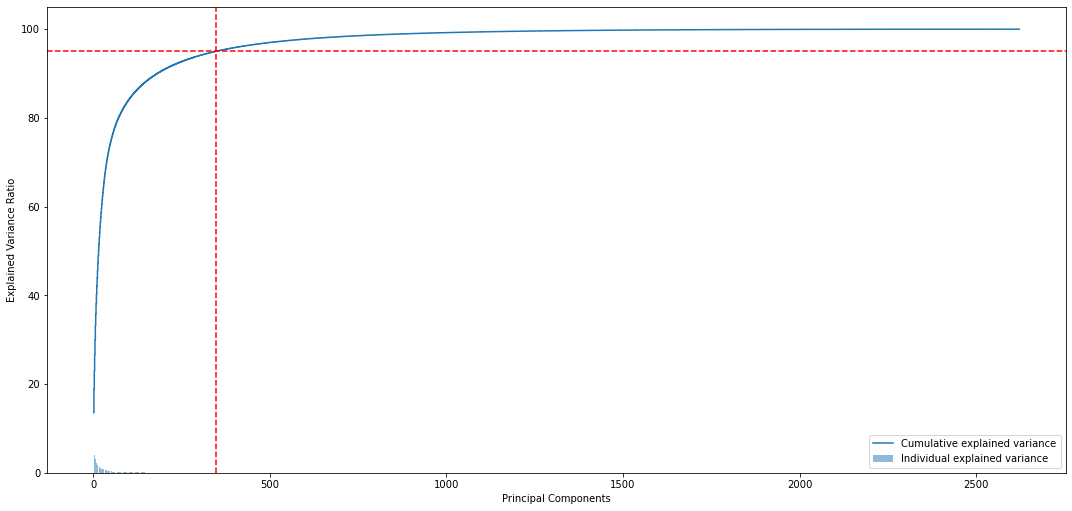

In [53]:
# Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [55]:
# Reducing the dimensions
random_state = 2020
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

In [57]:
from sklearn.svm import SVC
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [58]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [59]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

In [60]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

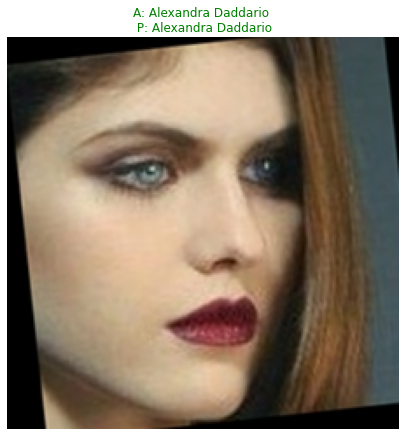

In [61]:
# Plot for 10th image in test data
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

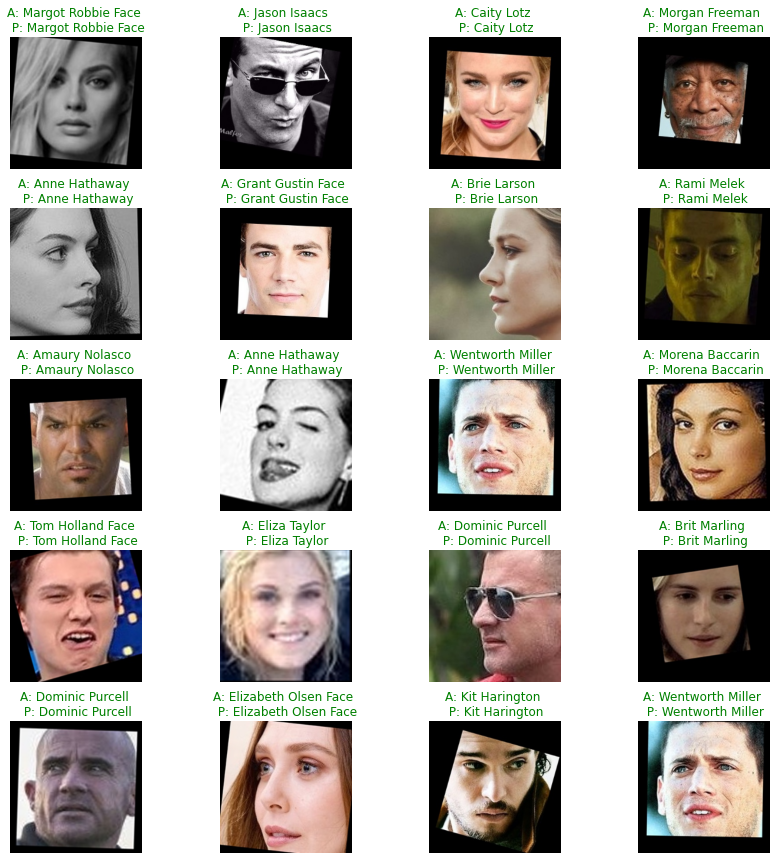

In [64]:
# Random 20 sample images from test data
import matplotlib.gridspec as gridspec
import random

plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

In [82]:
#Test on 2 images
img1 = cv2.imread('E:/mrinal/python/CV Project/Dwayne Johnson4.jpg')
img2 = cv2.imread('E:/mrinal/python/CV Project/Benedict+Cumberbatch9.jpg')

In [83]:
img1 = (img1/255.).astype(np.float32)

img1 = cv2.resize(img1, (224, 224))
embedding1 = vgg_face_descriptor.predict(np.expand_dims(img1, axis = 0))[0]

embedding_scaled1 = sc.transform(embedding1.reshape(1, -1))
 
sample_pred1 = svc_pca.predict(pca.transform(embedding_scaled1))
pred_name1 = en.inverse_transform(sample_pred1)[0].split('_')[-1].title().strip()

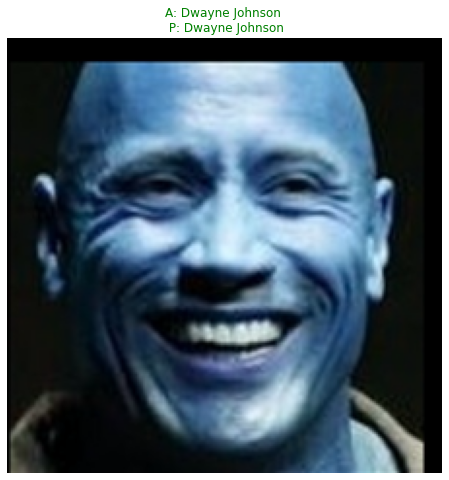

In [87]:
# Plot for 1st image
actual_name = 'Dwayne Johnson'
fig = plt.figure(figsize = (20, 8))
plt.axis('off')
plt.imshow(img1)
plt.title(f"A: {actual_name} \n P: {pred_name1}", color = 'green' if actual_name == pred_name1 else 'red')
plt.show()

In [84]:
img2 = (img2/255.).astype(np.float32)

img2 = cv2.resize(img2, (224, 224))
embedding2 = vgg_face_descriptor.predict(np.expand_dims(img2, axis = 0))[0]

embedding_scaled2 = sc.transform(embedding2.reshape(1, -1))
 
sample_pred2 = svc_pca.predict(pca.transform(embedding_scaled2))
pred_name2 = en.inverse_transform(sample_pred2)[0].split('_')[-1].title().strip()

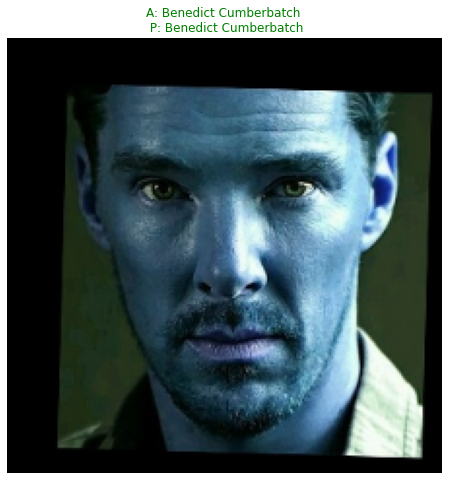

In [91]:
# Plot for 2nd image
actual_name = 'Benedict Cumberbatch'
fig = plt.figure(figsize = (20, 8))
plt.axis('off')
plt.imshow(img2)
plt.title(f"A: {actual_name} \n P: {pred_name2}", color = 'green' if actual_name == pred_name2 else 'red')
plt.show()